In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s5e6/sample_submission.csv
/kaggle/input/playground-series-s5e6/train.csv
/kaggle/input/playground-series-s5e6/test.csv


##  Step 1: Load and Inspect the Data

**Purpose**  
Load the training and test datasets to begin the analysis.



###  Actions

- Used `pd.read_csv()` to read the CSV files into pandas DataFrames.  
- Displayed the first few rows using `train.head()` and `test.head()` to understand the structure.



###  Key Observations

- Both datasets include the following features:
  - `Temparature`, `Humidity`, `Moisture`
  - `Soil Type`, `Crop Type`
  - `Nitrogen`, `Potassium`, `Phosphorous`

- The **target variable** is:
  - `Fertilizer Name` — a categorical label representing the recommended fertilizer.


In [2]:
# Load data
train = pd.read_csv('/kaggle/input/playground-series-s5e6/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s5e6/test.csv')
# Preview
print(train.head())
print(test.head())

   id  Temparature  Humidity  Moisture Soil Type  Crop Type  Nitrogen  \
0   0           37        70        36    Clayey  Sugarcane        36   
1   1           27        69        65     Sandy    Millets        30   
2   2           29        63        32     Sandy    Millets        24   
3   3           35        62        54     Sandy     Barley        39   
4   4           35        58        43       Red      Paddy        37   

   Potassium  Phosphorous Fertilizer Name  
0          4            5           28-28  
1          6           18           28-28  
2         12           16        17-17-17  
3         12            4        10-26-26  
4          2           16             DAP  
       id  Temparature  Humidity  Moisture Soil Type    Crop Type  Nitrogen  \
0  750000           31        70        52     Sandy        Wheat        34   
1  750001           27        62        45       Red    Sugarcane        30   
2  750002           28        72        28    Clayey  Ground

##  Step 2: Data Preprocessing – Encoding Categorical Features


**Purpose**  
Convert categorical variables into numerical representations for machine learning models.



###  Actions

- Identified categorical columns:
  - `Soil Type`
  - `Crop Type`
- Used `LabelEncoder` to convert these columns into numeric labels.
- Applied the same transformations to the test set to maintain consistency.
- Encoded the target variable `Fertilizer Name` to prepare it for classification.



###  Why ?

- Machine learning models require numerical input.  
- Encoding allows models to interpret categorical variables correctly.  
- Encoding the target ensures the model treats fertilizer labels as class indices for multi-class classification.


In [3]:
from sklearn.preprocessing import LabelEncoder

# Encode categorical features
cat_cols = ['Soil Type', 'Crop Type']
label_encoders = {}

for col in cat_cols:
    le = LabelEncoder()
    train[col] = le.fit_transform(train[col])
    test[col] = le.transform(test[col])

# Encode target
target_le = LabelEncoder()
train['Fertilizer Name'] = target_le.fit_transform(train['Fertilizer Name'])


##  Step 3: Feature Selection and Train/Validation Split

###  Explanation

**Purpose**  
Prepare the data for model training and evaluation.



###  Actions

- Selected relevant input features for the model:
  - `Temparature`, `Humidity`, `Moisture`, `Soil Type`, `Crop Type`, `Nitrogen`, `Potassium`, `Phosphorous`
- Split the data into:
  - `X_train`, `y_train` for training
  - `X_val`, `y_val` for validation
- Used `train_test_split()` with `stratify=y` to maintain class balance.



###  Why?

- A validation set is needed to evaluate model performance during development.  
- Stratified splitting ensures that all fertilizer classes are proportionally represented in both sets, avoiding bias.


In [4]:
from sklearn.model_selection import train_test_split

# Selecct Features
features = ['Temparature', 'Humidity', 'Moisture', 'Soil Type', 'Crop Type',
            'Nitrogen', 'Potassium', 'Phosphorous']

X = train[features]
y = train['Fertilizer Name']
X_test = test[features]

# Train/val split
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)



##  Step 4: Model Training – Random Forest Classifier

###  Explanation

**Purpose**  
Train a Random Forest classifier to predict the optimal fertiliser.



###  Actions

- Initialised `RandomForestClassifier` with the following parameters:
  - `n_estimators=100`: Builds 100 decision trees.
  - `max_depth=15`: Restricts tree depth to avoid overfitting.
  - `random_state=42`: Ensures consistent results.
  - `n_jobs=-1`: Utilises all CPU cores for faster training.
- Trained the model using `model1.fit(X_train, y_train)`.



###  Why Random Forest?

- Captures non-linear patterns effectively.  
- Tolerant to outliers and noise.  
- Requires minimal feature scaling or preprocessing.  
- Offers insights into feature importance, aiding interpretation.


In [5]:
from sklearn.ensemble import RandomForestClassifier

# Train model
model1 = RandomForestClassifier(n_estimators=100, max_depth=15, random_state=42, n_jobs=-1)
model1.fit(X_train, y_train)

RandomForestClassifier(max_depth=15, n_jobs=-1, random_state=42)

##  Step 5: Model Evaluation – MAP@3 Metric

###  Explanation

**Purpose**  
Evaluate the model using the Mean Average Precision at K (MAP@3) metric.



###  Actions

- Defined a custom `mapk()` function to calculate MAP@3.
- Predicted class probabilities for the validation set using `model1.predict_proba()`.
- Selected the top 3 predicted classes for each sample using `np.argsort()`.
- Converted predicted class indices back to fertiliser names using `LabelEncoder.inverse_transform()`.
- Computed and printed the MAP@3 score (e.g., `0.3072`).



###  Why MAP@3 ?

- Fertiliser recommendation may involve several suitable options.
- MAP@3 measures whether the true label is among the top 3 predictions.
- Encourages the model to rank correct labels higher, not just predict a single class.


In [6]:
# MAP@3 function
def mapk(actual, predicted, k=3):
    def apk(a, p, k):
        if a in p[:k]:
            return 1.0 / (p[:k].index(a) + 1)
        return 0.0
    return np.mean([apk(a, p, k) for a, p in zip(actual, predicted)])

# Validation
val_probs = model1.predict_proba(X_val)
val_top3 = np.argsort(val_probs, axis=1)[:, -3:][:, ::-1]
val_preds = target_le.inverse_transform(val_top3.ravel()).reshape(val_top3.shape)
val_true = target_le.inverse_transform(y_val)

print("Validation MAP@3:", round(mapk(val_true, val_preds.tolist(), k=3), 4))


Validation MAP@3: 0.3072


##  Step 6: Model Training – XGBoost Classifier


**Purpose**  
Train an XGBoost classifier as an alternative to Random Forest.



###  Actions

- Initialised `XGBClassifier` with the following settings:
  - `objective='multi:softprob'`: For multi-class classification with probability outputs.
  - `eval_metric='mlogloss'`: Uses log loss to evaluate predictions.
  - `max_depth=8`: Controls tree depth to reduce overfitting.
  - `n_estimators=100`: Sets the number of boosting rounds.
  - `learning_rate=0.1`: Controls the step size in updates.
- Trained the model using `model.fit(X_train, y_train)`.



###  Why XGBoost ?

- Often outperforms Random Forest by using gradient boosting.  
- More accurate on structured/tabular data.  
- Handles imbalanced datasets well.  
- Provides built-in feature importance for interpretation.


In [7]:
from xgboost import XGBClassifier
# XGBoost model
model2 = XGBClassifier(objective='multi:softprob',
    num_class=len(np.unique(y)),eval_metric='mlogloss',
    use_label_encoder=False,max_depth=8,
    n_estimators=100,learning_rate=0.1,
    random_state=42,verbosity=0)

model2.fit(X_train, y_train)



XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_class=7, num_parallel_tree=None, ...)

##  Step 7: Model Evaluation Using MAP@3 Metric

###  Purpose

Evaluate the model's performance using the **Mean Average Precision at K (MAP@3)** metric. This is important for:

- Multi-class classification tasks where multiple predictions can be valid.
- Cases where we want to consider the top K predictions, not just the single best guess.
- Fertiliser recommendation, where multiple options may work.



###  Step-by-Step Explanation

####  MAP@3 Function Definition

- `mapk()` calculates the **mean average precision at K**
- Nested `apk()` function handles **average precision per sample**

**How it works:**
- If the correct label is among the top K predictions:  
  → returns `1 / (rank of correct label)`
- If not in top K:  
  → returns `0`
- Final MAP@3 score is the mean of all sample scores



####  Validation Predictions

- `model2.predict_proba()` generates class probabilities for validation samples
- `np.argsort(probs, axis=1)[:, -3:][:, ::-1]` extracts **indices of top 3 predictions**:
  - Sorts in ascending order.
  - Takes the last 3 (most probable).
  - Reverses to get descending order.
- `target_le.inverse_transform()` converts predicted class indices back to fertiliser names.



####  MAP@3 Calculation

- Compares `val_true` (true labels) with `val_preds` (top 3 predictions)
- Score range:  
  `0` (worst) → `1` (perfect)
- Higher score means the correct label appears earlier in the prediction list



####  Test Predictions Generation

- Same process used on the test dataset.
- Results stored in `test_top3_labels`
- Predictions formatted for Kaggle submission.



###  Why MAP@3 for Fertiliser Recommendation ?

#### Practical Relevance

- There can be **multiple suitable fertilizers** for each scenario.
- Farmers benefit from **alternative recommendations**.

####  Evaluation Benefits

- More informative than accuracy.
- Rewards models that rank correct labels **higher**.
- Penalizes models that miss the correct label.

####  Interpretation

- A score of `0.3072` means:
  - On average, the correct fertiliser appears in the model’s **top 3 predictions**.
  - Higher score = better ranking performance.
  - Leaves room for improvement and model tuning.

In [8]:
# MAP@3 function
def mapk(actual, predicted, k=3):
    def apk(a, p, k):
        if a in p[:k]:
            return 1.0 / (p[:k].index(a) + 1)
        return 0.0
    return np.mean([apk(a, p, k) for a, p in zip(actual, predicted)])

# Validation
val_probs = model2.predict_proba(X_val)
val_top3 = np.argsort(val_probs, axis=1)[:, -3:][:, ::-1]
val_preds = target_le.inverse_transform(val_top3.ravel()).reshape(val_top3.shape)
val_true = target_le.inverse_transform(y_val)

print("Validation MAP@3:", round(mapk(val_true, val_preds.tolist(), k=3), 4))



Validation MAP@3: 0.3235


##  Step 7: Feature Importance Visualization



**Purpose**  
Identify which features have the greatest impact on the model's predictions.



###  Actions

- Used `plot_importance()` from XGBoost to create a feature importance chart.
- Selected the **top 10 features** using `importance_type='gain'`, which measures:
  - The **total gain** (improvement in accuracy) each feature contributes to decision splits.



###  Key Observations

- Features such as:
  - `Nitrogen`, `Phosphorous`, `Potassium`
  - are likely among the most important.
- These features relate directly to nutrient levels in the soil and have a strong influence on fertiliser choice.


<Figure size 1000x600 with 0 Axes>

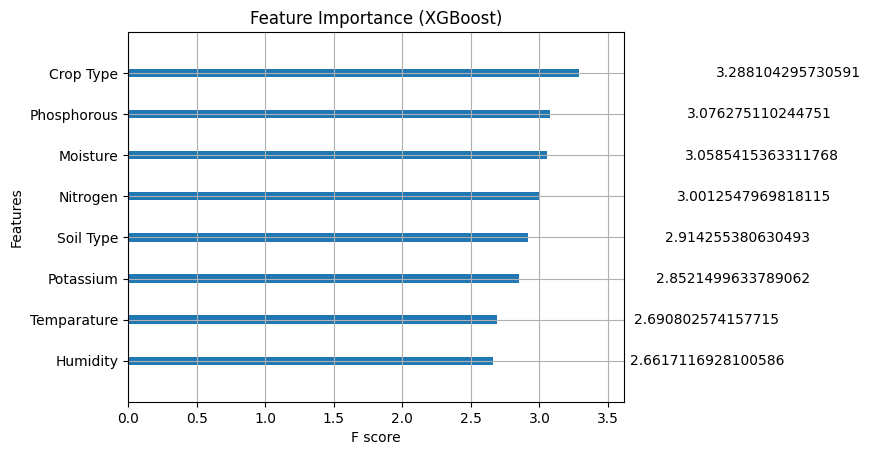

In [9]:
import matplotlib.pyplot as plt
from xgboost import plot_importance

# Plot feature importance
plt.figure(figsize=(10, 6))
plot_importance(model2, max_num_features=10, importance_type='gain')
plt.title("Feature Importance (XGBoost)")
plt.show()

##  Step 8: Comprehensive Model Comparison


**Purpose**  
Compare the performance and interpretability of multiple trained models using visual and statistical diagnostics.



###  Actions

- Created a reusable `compare_models()` function that:
  - Plots feature importances for each model (bar chart or XGBoost-specific).
  - Displays confusion matrices (normalised) for visual accuracy assessment.
  - Generates detailed classification reports (precision, recall, F1-score).

- Evaluated both:
  - `Random Forest` (model1)
  - `XGBoost` (model2)



###  Visual Output

- **Feature Importance**
  - Shows how much each feature contributed to predictions.
  - Helps explain model behaviour.

- **Confusion Matrix**
  - Compares predicted vs actual class distribution.
  - Highlights any systematic misclassifications.



###  Classification Report

- Displays metrics for each fertiliser class:
  - **Precision**: How many predictions were actually correct.
  - **Recall**: How many actual cases were correctly predicted.
  - **F1-score**: Balance between precision and recall.
- Also includes weighted averages across all classes.



###  Benefit

This step helps you:
- Understand which model performs better overall.
- See where models are misclassifying.
- Compare model decision patterns based on feature usage.


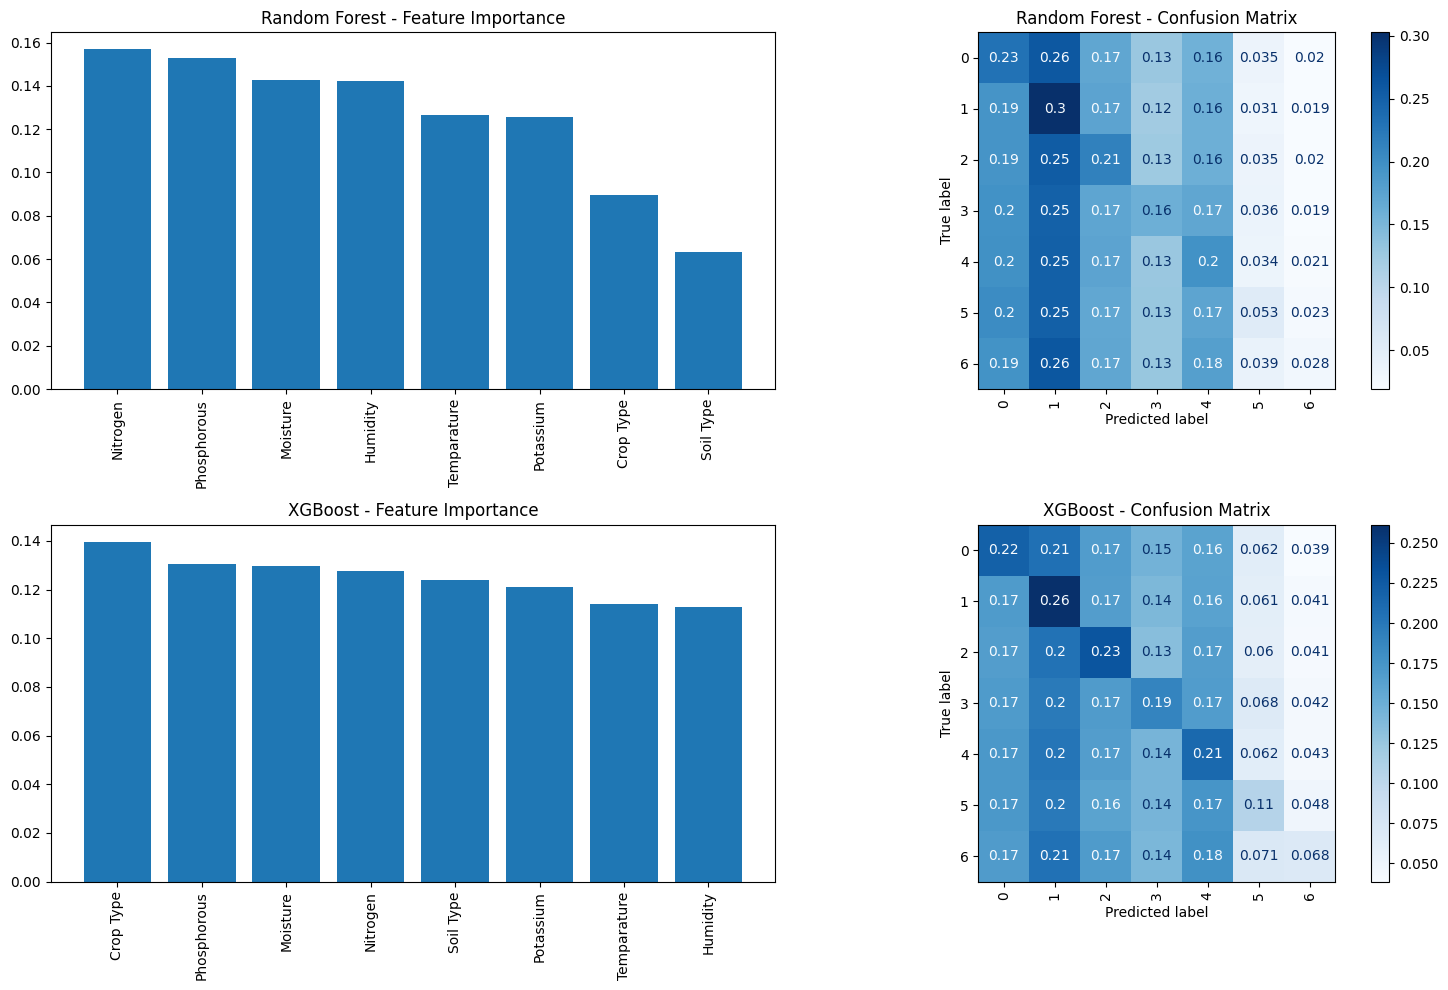


Classification Report for Random Forest:


,precision,recall,f1-score,support
0,0.174004,0.230101,0.198159,22777.000000
1,0.176874,0.302836,0.223318,22887.000000
2,0.180220,0.213730,0.195550,22491.000000
3,0.178881,0.159257,0.168499,22178.000000
4,0.170707,0.196069,0.182511,22232.000000
5,0.180240,0.053078,0.082007,18972.000000
6,0.162651,0.027785,0.047463,18463.000000
accuracy,0.175933,0.175933,0.175933,0.175933
macro avg,0.174797,0.168979,0.156787,150000.000000
weighted avg,0.174998,0.175933,0.161662,150000.000000



Classification Report for XGBoost:


,precision,recall,f1-score,support
0,0.188732,0.219432,0.202927,22777.000000
1,0.188816,0.261284,0.219216,22887.000000
2,0.195634,0.229114,0.211054,22491.000000
3,0.188746,0.189061,0.188904,22178.000000
4,0.180840,0.212531,0.195409,22232.000000
5,0.193813,0.105682,0.136781,18972.000000
6,0.185364,0.068461,0.099992,18463.000000
accuracy,0.188787,0.188787,0.188787,0.188787
macro avg,0.188850,0.183652,0.179183,150000.000000
weighted avg,0.188840,0.188787,0.182407,150000.000000


In [10]:
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def compare_models(models, model_names, X_val, y_val):
    """
    Compare multiple models' performance and feature importances
    
    Parameters:
    models - list of trained model objects
    model_names - list of model names (strings)
    X_val - validation features
    y_val - validation labels
    """
    # Create subplots
    fig, axes = plt.subplots(nrows=len(models), ncols=2, figsize=(15, 5*len(models)))
    if len(models) == 1:
        axes = np.array([axes])
    
    # Evaluate each model
    results = []
    for i, (model, name) in enumerate(zip(models, model_names)):
        # Get predictions
        y_pred = model.predict(X_val)
        y_proba = model.predict_proba(X_val)
        
        # Classification report
        report = classification_report(y_val, y_pred, output_dict=True)
        df_report = pd.DataFrame(report).transpose()
        results.append(df_report)
        
        # Plot feature importance
        if hasattr(model, 'feature_importances_'):
            # For models with feature_importances_ attribute
            importances = model.feature_importances_
            indices = np.argsort(importances)[::-1]
            
            axes[i,0].set_title(f'{name} - Feature Importance')
            axes[i,0].bar(range(X_val.shape[1]), importances[indices])
            axes[i,0].set_xticks(range(X_val.shape[1]))
            axes[i,0].set_xticklabels(X_val.columns[indices], rotation=90)
            
        elif hasattr(model, 'get_booster'):
            # For XGBoost models
            from xgboost import plot_importance
            plot_importance(model, ax=axes[i,0], importance_type='gain', max_num_features=10)
            axes[i,0].set_title(f'{name} - Feature Importance')
        
     # Plot confusion matrix
        from sklearn.metrics import ConfusionMatrixDisplay
        ConfusionMatrixDisplay.from_predictions(y_val, y_pred, ax=axes[i,1], 
                                              xticks_rotation='vertical', 
                                              cmap='Blues', 
                                              normalize='true')
        axes[i,1].set_title(f'{name} - Confusion Matrix')
    
    plt.tight_layout()
    plt.show()
    
    # Display classification reports
    for name, report in zip(model_names, results):
        print(f"\nClassification Report for {name}:")
        display(report)
    
    return results

# Usage example:
models = [model1, model2]  # Your trained models
model_names = ['Random Forest', 'XGBoost']
results = compare_models(models, model_names, X_val, y_val)

##  Step 9: Generate Submission File


  
Create the final submission file for Kaggle using the model’s top 3 fertiliser predictions.



###  Actions

- Used `model2.predict_proba(X_test)` to generate predicted class probabilities on the test set.
- Selected the top 3 predicted fertiliser labels per row.
 

In [11]:
# Test predictions
test_probs = model2.predict_proba(X_test)
test_top3_idx = np.argsort(test_probs, axis=1)[:, -3:][:, ::-1]
test_top3_labels = target_le.inverse_transform(test_top3_idx.ravel()).reshape(test_top3_idx.shape)

# Submission
submission = pd.DataFrame({'id': test['id'],'Fertilizer Name': [' '.join(map(str, row)) for row in test_top3_labels]})

submission.to_csv("submission.csv", index=False)
print("submission.csv created")

submission.csv created
